### **Import**

In [1]:
from data_processing import setup_folders, process_pdfs
from question_generator import run_question_generation
from retriever_model import load_all_documents, build_faiss_index, load_retriever, build_qa_chain
from evaluation import evaluate_dataframe, statistics
from visualize import plot_score_distributions, plot_correlation_heatmap, plot_overall_histogram

import pandas as pd
import os

### **Setup folders and process PDFs**

In [2]:
setup_folders()
metadata = process_pdfs()

Created folders: session_1, session_1/chunks
Processing: 2024-amazon-annual-report-10K.pdf
Finished 2024-amazon-annual-report-10K.pdf: 112 chunks, 47161 words.
Processing: 2024-tsla-annual-report-10K.pdf
Finished 2024-tsla-annual-report-10K.pdf: 179 chunks, 51096 words.
Processing: 2024-reddit-annual-report-10K.pdf
Finished 2024-reddit-annual-report-10K.pdf: 146 chunks, 67565 words.
Processing: 2024-oracle-annual-report-10K.pdf
Finished 2024-oracle-annual-report-10K.pdf: 217 chunks, 62640 words.
Processing: 2024-nvidia-annual-report-10K.pdf
Finished 2024-nvidia-annual-report-10K.pdf: 224 chunks, 93680 words.
Processing: 2024-apple-annual-report-10K.pdf
Finished 2024-apple-annual-report-10K.pdf: 134 chunks, 57814 words.
Processing: 2024-google-annual-report-10K.pdf
Finished 2024-google-annual-report-10K.pdf: 123 chunks, 51919 words.
Processing: 2024-netflix-annual-report-10K.pdf
Finished 2024-netflix-annual-report-10K.pdf: 105 chunks, 36885 words.
Processing: 2024-cisco-full-annual-repo

### **Generate Questions**

In [3]:
questions_df = run_question_generation(metadata, save=True)
questions_df.head()

Saved 10 questions to session_1/questions.csv


,file_name,format_name,file_path,summary,chunk,chunk_id,question
0,2024-amazon-annual-report-10K.pdf,2024-amazon-annual-report-10K,annual_report/2024-amazon-annual-report-10K.pdf,"The report is about Amazon.com, Inc. and cover...","operating expenses include “Cost of sales,” “F...",98,"How does Amazon.com, Inc.'s Chief Operating De..."
1,2024-tsla-annual-report-10K.pdf,2024-tsla-annual-report-10K,annual_report/2024-tsla-annual-report-10K.pdf,"The report is about Tesla, Inc. and covers the...","105\n5/25/25, 1:46 PM\ntsla-20241231\nhttps://...",175,"Based on the Tesla, Inc. 2024 fiscal year repo..."
2,2024-reddit-annual-report-10K.pdf,2024-reddit-annual-report-10K,annual_report/2024-reddit-annual-report-10K.pdf,"The report is the annual Form 10-K for Reddit,...",The absolute number of our DAUq and our DAUq g...,18,"Based on the Reddit, Inc. 2024 Form 10-K, how ..."
3,2024-oracle-annual-report-10K.pdf,2024-oracle-annual-report-10K,annual_report/2024-oracle-annual-report-10K.pdf,The report is about Oracle Corporation and cov...,ORACLE CORPORATION\nFISCAL YEAR 2024\nFORM 10-...,2,Based on the Oracle Corporation fiscal year 20...
4,2024-nvidia-annual-report-10K.pdf,2024-nvidia-annual-report-10K,annual_report/2024-nvidia-annual-report-10K.pdf,The report is about NVIDIA Corporation and cov...,management and directors of the company; and (...,180,What does NVIDIA Corporation's fiscal year 202...


### **Build Retriever and QA Chain**

In [4]:
chunks = load_all_documents()
faiss_index = build_faiss_index(chunks)
retriever = load_retriever()
qa_chain = build_qa_chain(retriever)

Loaded 1182 total pages
Split into 1426 chunks.


/home/landao/DATA_4380_Homework/LLM/retriever_model.py:36: LangChainDeprecationWarning:

The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.

2025-08-05 17:20:01.055839: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 17:20:01.207738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754432401.266362     472 cuda_dnn.cc:85

Vector store saved to faiss_index_open


/home/landao/DATA_4380_Homework/LLM/retriever_model.py:60: LangChainDeprecationWarning:

The class `ChatPerplexity` was deprecated in LangChain 0.3.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-perplexity package and should be used instead. To use it run `pip install -U :class:`~langchain-perplexity` and import as `from :class:`~langchain_perplexity import ChatPerplexity``.



### **Run Retrieval Q&A on generated questions**

In [5]:
questions_df["answer"] = questions_df["question"].apply(lambda q: qa_chain.invoke({"query": q})["result"])
questions_df.to_csv(os.path.join("session_1", "answers.csv"), index=False)
questions_df[["question", "answer"]].head()

,question,answer
0,"How does Amazon.com, Inc.'s Chief Operating De...",Amazon.com's Chief Operating Decision Maker (C...
1,"Based on the Tesla, Inc. 2024 fiscal year repo...","For Tesla's 2024 fiscal year, the key financia..."
2,"Based on the Reddit, Inc. 2024 Form 10-K, how ...","According to Reddit, Inc.'s 2024 Form 10-K, ex..."
3,Based on the Oracle Corporation fiscal year 20...,The main sections included in the Oracle Corpo...
4,What does NVIDIA Corporation's fiscal year 202...,NVIDIA Corporation's fiscal year 2024 report s...


### **Evaluate Answers**

In [6]:
evaluated_df = evaluate_dataframe(questions_df)
evaluated_df.to_csv(os.path.join("session_1", "evaluated.csv"), index=False)
evaluated_df.head()

# Show descriptive statistics
statistics(evaluated_df)

,count,mean,std,min,median,max
evaluation_factual_correctness_score,10.00,4.60,0.97,2.00,5.00,5.00
evaluation_completeness_score,10.00,4.60,0.97,2.00,5.00,5.00
evaluation_clarity_score,10.00,4.90,0.32,4.00,5.00,5.00
overall_score,10.00,4.70,0.74,2.67,5.00,5.00


### **Visualize Scores**

In [7]:
plot_score_distributions(evaluated_df)

In [8]:
plot_correlation_heatmap(evaluated_df)

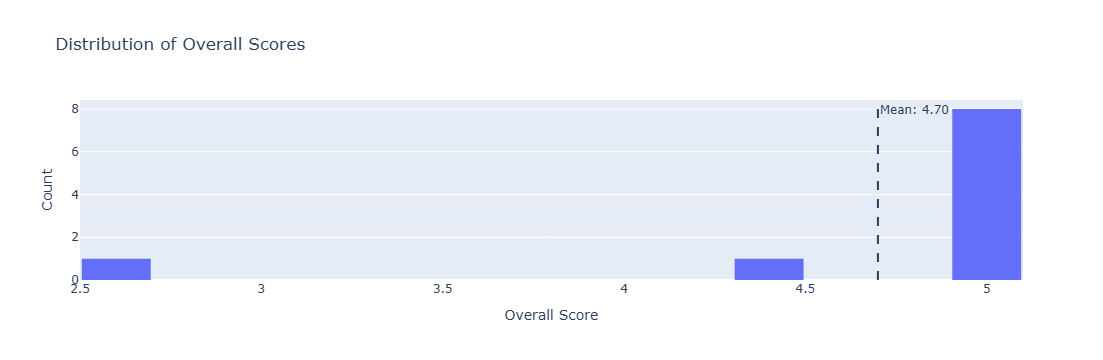

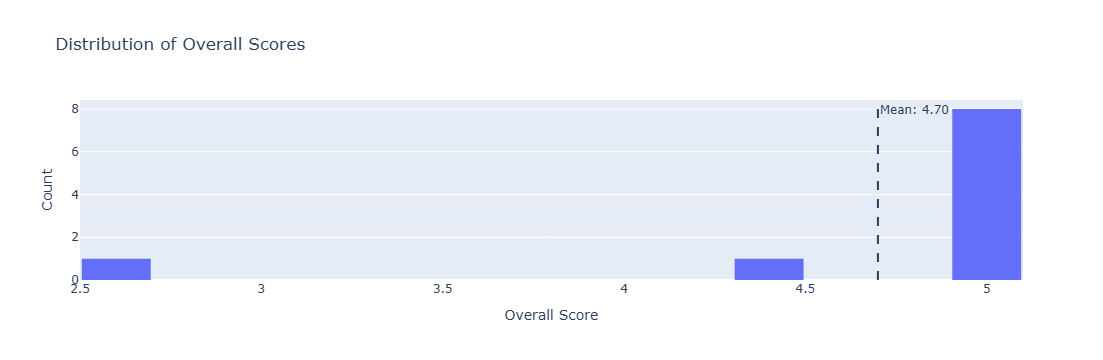

In [9]:
plot_overall_histogram(evaluated_df)